## CIFAR 10

Initial attempt to get cifar10 to converge faster following Leslie Smith's 2 papers:
* Superconvergence - https://arxiv.org/abs/1708.07120
* Neural network hyperparameters - https://arxiv.org/abs/1803.09820

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH,exist_ok=True)

### Load classes

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
bs=128

## Initial model

In [6]:
from fastai.models.cifar10.resnext import resnext29_8_64

m = resnext29_8_64()
bm = BasicModel(m.cuda(), name='cifar10_rn29_8_64')

In [8]:
data = get_data(8,512)

In [9]:
learn = ConvLearner(data, bm)
learn.unfreeze()

In [15]:
# lr=5e-1; wd=1e-4
lr=1e-2; wd=5e-4

In [16]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      3.633369   1305988352.0 0.097656  



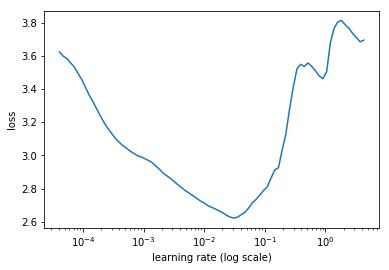

In [17]:
learn.sched.plot()

In [18]:
%time learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.809645   1.580666   0.433789  

CPU times: user 1min 5s, sys: 21.8 s, total: 1min 27s
Wall time: 1min 14s


[1.580666, 0.4337890625]

In [19]:
learn.save('8x8_8e1')

In [20]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.50497    1.434532   0.486052  
    1      1.415007   1.368073   0.510271                 

CPU times: user 2min 11s, sys: 44.3 s, total: 2min 55s
Wall time: 2min 31s


[1.3680726, 0.5102711409330368]

In [21]:
learn.save('8x8_8e2')

In [22]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.354197   1.334107   0.52558   
    1      1.352628   1.315906   0.527223                 
    2      1.217196   1.258691   0.550408                 
    3      1.284034   1.307312   0.531945                 
    4      1.196233   1.24165    0.553326                 
    5      1.077603   1.194678   0.577447                 
    6      0.988323   1.186951   0.582215                  

CPU times: user 8min 14s, sys: 2min 12s, total: 10min 26s
Wall time: 8min 49s


[1.1869509, 0.5822150737047196]

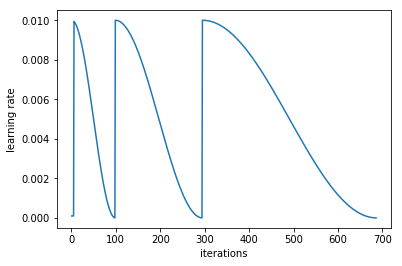

In [23]:
learn.sched.plot_lr()

In [24]:
learn.save('8x8_8e3')

## Playing around with CLR and high learning rates

Test:  
Loading the model from a checkpoint we've saved above (initial model)  
Try to beat the accuracy we've gotten in less epochs  

### Epoch 2 - Test 1: CLR with high LR (.5)

In [48]:
learn.load('8x8_8e1')

In [49]:
lr=5e-1; wd=1e-4

In [50]:
%time learn.fit(lr, 1, cycle_len=2, use_clr=(10, 1), wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.850457   1.582407   0.427102  
    1      1.511062   1.377433   0.500844                 

CPU times: user 2min 19s, sys: 36.9 s, total: 2min 56s
Wall time: 2min 28s


[1.377433, 0.5008444398641586]

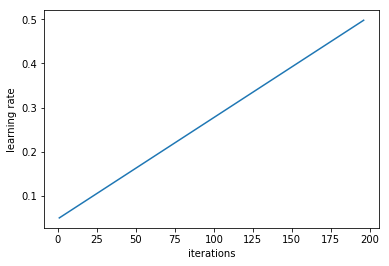

In [40]:
learn.sched.plot_lr()

In [51]:
learn.save('8x8_8e2_clr10-1_highlr')

### Test 2: Run 4 epochs

In [52]:
learn.load('8x8_8e1')

In [53]:
lr=8e-1; wd=1e-4

In [54]:
%time learn.fit(lr, 1, cycle_len=4, use_clr=(10, 1), wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.889845   3.274998   0.359576  
    1      1.52407    1.384474   0.499253                 
    2      1.372817   1.379251   0.497995                 
    3      1.260595   1.217268   0.567894                 

CPU times: user 4min 41s, sys: 1min 18s, total: 5min 59s
Wall time: 5min 1s


[1.2172681, 0.5678940713405609]

In [55]:
learn.save('8x8_8e2_clr10-1_clen4')

### Test 3: Cycle len 6. Out performs "Initial Model". Higher accuracy with less epochs

In [56]:
learn.load('8x8_8e1')

In [57]:
lr=8e-1; wd=1e-4

In [58]:
%time learn.fit(lr, 1, cycle_len=6, use_clr=(10, 2), wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.97695    1.577946   0.419818  
    1      1.579179   1.433      0.481124                 
    2      1.425466   1.309537   0.52492                  
    3      1.283533   1.21617    0.561644                 
    4      1.124753   1.058623   0.624414                 
    5      0.974473   0.945639   0.665711                  

CPU times: user 7min 2s, sys: 1min 53s, total: 8min 55s
Wall time: 7min 31s


[0.9456395, 0.6657111674547196]

In [59]:
learn.save('8x8_8e2_clr10-2_clen6')

### 16x16 - Original

In [23]:
learn.load('8x8_8e2_clr10-2_clen6')

In [99]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  6%|▌         | 6/98 [00:04<01:12,  1.28it/s, loss=1.56]

Exception in thread Thread-103:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.381085   2.238309   0.431342  



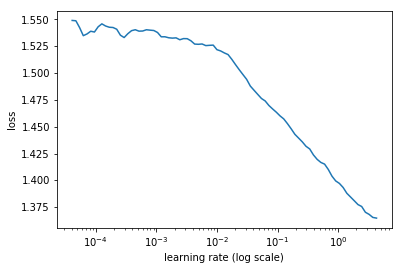

In [100]:
learn.sched.plot()

In [24]:
lr=1e-2; wd=5e-5
learn.unfreeze()

In [ ]:
%time learn.fit(lr, 2, cycle_len=1, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  7%|▋         | 7/98 [00:08<01:47,  1.18s/it, loss=1.36]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.11208    1.067797   0.614941  
 13%|█▎        | 13/98 [00:14<01:34,  1.11s/it, loss=1.1]

In [ ]:
learn.save('16x16_8e1')

In [18]:
lr=1e-2; wd=5e-5

In [19]:
learn.unfreeze()
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.701996   0.663622   0.764763  
    1      0.662553   0.628094   0.780113                  
 60%|██████    | 59/98 [01:01<00:40,  1.05s/it, loss=0.59] 

KeyboardInterrupt: 

In [20]:
learn.save('16x16_8')

## 16x16 - Testing high LR

Load the best model we got from above.  
See if we can beat accuracy and speed of the 16x16 training here: https://github.com/fastai/fastai/blob/master/courses/dl1/cifar10.ipynb

In [12]:
# learn.load('8x8_8')
learn.load('8x8_8e2_clr10-2_clen6')

In [13]:
learn.set_data(get_data(16,512))

In [107]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 22%|██▏       | 22/98 [00:09<00:31,  2.43it/s, loss=1.53]

Exception in thread Thread-109:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.357268   2.46283    0.454716  



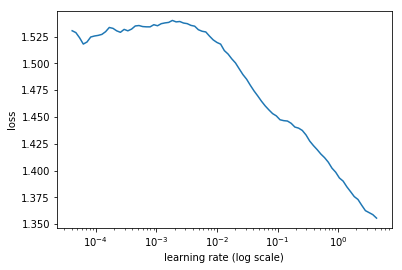

In [108]:
learn.sched.plot()

In [111]:
lr=1; wd=1e-4

In [112]:
# %time learn.fit(1e-3, 1, wds=wd)
%time learn.fit(lr, 1, cycle_len=6, use_clr=(10, 3), wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.195785   1.147329   0.588356  
    1      1.14185    1.090442   0.614758                 
    2      1.102608   1.063991   0.621295                 
    3      1.071542   1.052617   0.629889                 
    4      1.0589     1.041102   0.633048                 
    5      1.044476   1.030845   0.630991                 

CPU times: user 3min 58s, sys: 1min 41s, total: 5min 40s
Wall time: 4min 28s


[1.0308453, 0.6309914976358414]

In [113]:
learn.save('16x16_8_clr5-2')

## 24x24

In [ ]:
learn.load('16x16_8')

In [ ]:
learn.set_data(get_data(24,bs))

In [ ]:
%time learn.fit(1e-2, 1, wds=wd)

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit(lr, 1, cycle_len=1, wds=wd)

In [ ]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
learn.save('24x24_8')

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)metrics.log_loss(y,preds), accuracy(preds,y)

## 32x32

In [ ]:
learn.load('24x24_8')

In [ ]:
learn.set_data(get_data(32,bs))

In [ ]:
%time learn.fit(1e-2, 1, wds=wd)

In [ ]:
learn.unfreeze()

In [ ]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(lr, 3, cycle_len=4, wds=wd)

In [ ]:
log_preds,y = learn.TTA()
metrics.log_loss(y,np.exp(log_preds)), accuracy(log_preds,y)

In [ ]:
learn.save('32x32_8')